In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, accuracy_score, recall_score,precision_score
from sklearn.preprocessing import StandardScaler, normalize

### On active l'utilisation du GPU pour accélérer l'entrainement des modèles

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
mirrored_strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### On récupère les données

In [3]:
test_data = pd.read_csv('./data/exoTest.csv')
train_data = pd.read_csv('./data/exoTrain.csv')

### Exploration des données

#### Aperçu des données

In [4]:
train_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [5]:
test_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


In [6]:
columns = list(train_data.columns)
columns

['LABEL',
 'FLUX.1',
 'FLUX.2',
 'FLUX.3',
 'FLUX.4',
 'FLUX.5',
 'FLUX.6',
 'FLUX.7',
 'FLUX.8',
 'FLUX.9',
 'FLUX.10',
 'FLUX.11',
 'FLUX.12',
 'FLUX.13',
 'FLUX.14',
 'FLUX.15',
 'FLUX.16',
 'FLUX.17',
 'FLUX.18',
 'FLUX.19',
 'FLUX.20',
 'FLUX.21',
 'FLUX.22',
 'FLUX.23',
 'FLUX.24',
 'FLUX.25',
 'FLUX.26',
 'FLUX.27',
 'FLUX.28',
 'FLUX.29',
 'FLUX.30',
 'FLUX.31',
 'FLUX.32',
 'FLUX.33',
 'FLUX.34',
 'FLUX.35',
 'FLUX.36',
 'FLUX.37',
 'FLUX.38',
 'FLUX.39',
 'FLUX.40',
 'FLUX.41',
 'FLUX.42',
 'FLUX.43',
 'FLUX.44',
 'FLUX.45',
 'FLUX.46',
 'FLUX.47',
 'FLUX.48',
 'FLUX.49',
 'FLUX.50',
 'FLUX.51',
 'FLUX.52',
 'FLUX.53',
 'FLUX.54',
 'FLUX.55',
 'FLUX.56',
 'FLUX.57',
 'FLUX.58',
 'FLUX.59',
 'FLUX.60',
 'FLUX.61',
 'FLUX.62',
 'FLUX.63',
 'FLUX.64',
 'FLUX.65',
 'FLUX.66',
 'FLUX.67',
 'FLUX.68',
 'FLUX.69',
 'FLUX.70',
 'FLUX.71',
 'FLUX.72',
 'FLUX.73',
 'FLUX.74',
 'FLUX.75',
 'FLUX.76',
 'FLUX.77',
 'FLUX.78',
 'FLUX.79',
 'FLUX.80',
 'FLUX.81',
 'FLUX.82',
 'FLUX.83',
 'F

In [7]:
train_data_2 = train_data.copy()

In [8]:
train_data_2.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,1.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,1.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,1.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,1.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,2.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


In [9]:
train_data_2['min'] = train_data_2.min(axis=1)
train_data_2['max'] = train_data_2.max(axis=1)
train_data_2['mean'] = train_data_2.mean(axis=1)
train_data_2['std'] = train_data_2.std(axis=1)
train_data_2[['LABEL','min','max', 'mean', 'std']]

,LABEL,min,max,mean,std
0,2,-1053.97,504.46,9.773428,161.961380
1,2,-371.27,252.64,-7.457416,60.492589
2,2,-874.95,1274.59,8.306922,283.019329
3,2,-268.41,370.29,-4.609769,103.492004
4,2,-1808.76,924.32,-14.503072,408.438733
...,...,...,...,...,...
5082,1,-197.04,348.63,12.522534,72.924204
5083,1,-1127.09,1214.44,8.460909,210.815289
5084,1,-664.93,1383.85,3.161981,67.061330
5085,1,-16.41,525.23,0.961675,14.361784


In [10]:
train_data_2.loc[train_data_2['LABEL'] == 2].std(axis=1).mean()

1120.4188557968089

In [11]:
train_data_2.loc[train_data_2['LABEL'] == 1].std(axis=1).mean()

1277.0273055195025

#### On observe la répartition des données

In [12]:
train_data['LABEL'].value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

1    5050
2      37
Name: LABEL, dtype: int64


Text(0.5, 1.0, 'Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)')

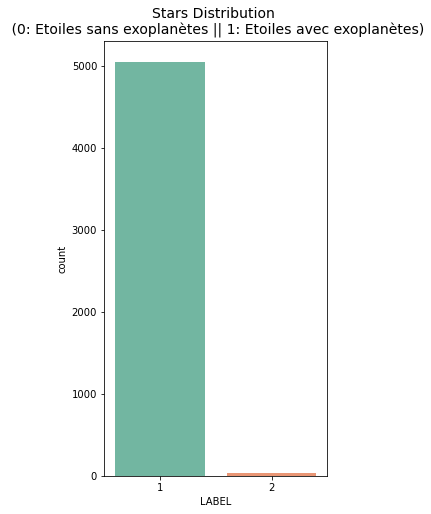

In [13]:
plt.figure(figsize=(4,8))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data, palette = "Set2")
print(train_data['LABEL'].value_counts())
plt.title('Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)', fontsize=14)

#### Les données sont nettoyées mais on vérifie qu'il n'y a pas de données manquantes au cas où

In [14]:
print("Nombre de valeurs nulles : " + str(train_data.isnull().sum().sum()))

Nombre de valeurs nulles : 0


### Affichage des corrélations

In [15]:
# corrMatrix = train_data.corr()
# corrMatrix['LABEL'].sort_values(ascending=False) 

In [16]:
# plt.figure(figsize=(15,15))
# sns.heatmap(train_data.corr())
# plt.title('Correlation in the data')
# plt.show()

### On sait que les étoiles ayant potentiellement des exoplanètes en orbites autour d'elles subissent une variation de leur "flux", de leur intensité lumineuse


##### Commençons avec les étoiles ne possédant pas d'exploplanetes

In [17]:
train_data.loc[train_data['LABEL'] == 1]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
37,1,-141.22,-81.79,-52.28,-32.45,-1.55,-35.61,-23.28,19.45,53.11,...,-50.79,-22.34,-36.23,27.44,13.52,38.66,-17.53,31.49,31.38,50.03
38,1,-35.62,-28.55,-27.29,-28.94,-15.13,-51.06,2.67,-5.21,9.67,...,-43.98,-38.22,-46.23,-54.40,-23.51,-26.96,-3.95,-0.34,10.52,-7.69
39,1,142.40,137.03,93.65,105.64,98.22,99.06,86.40,60.78,45.18,...,-0.99,-3.03,-30.27,-24.22,-35.10,-39.64,23.78,23.40,-0.50,0.97
40,1,-167.02,-137.65,-150.05,-136.85,-98.73,-103.14,-107.70,-123.19,-125.65,...,-97.43,-79.79,-80.62,-78.22,-105.06,-69.67,-90.45,-73.67,-66.71,-66.07
41,1,207.74,223.60,246.15,224.06,210.77,189.56,172.68,170.31,148.79,...,-53.06,-136.92,-174.97,-180.46,-164.01,-126.58,84.05,63.81,108.36,78.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


##### On sélectionne 3 étoiles parmi les concernées (ici la ligne 37,2500 et 5086)

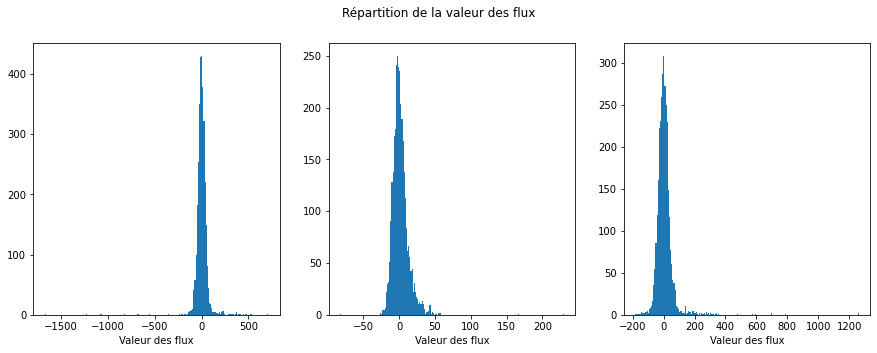

In [18]:
labels_1=[37,2500,5086]


fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(train_data.iloc[37,:], bins=200)
ax[1].hist(train_data.iloc[2500,:], bins=200)
ax[2].hist(train_data.iloc[5086,:], bins=200)

ax[0].set_xlabel("Valeur des flux")
ax[1].set_xlabel("Valeur des flux")
ax[2].set_xlabel("Valeur des flux")
fig.suptitle("Répartition de la valeur des flux")

plt.show()

##### On remarque que l'intensité lumineuse de ces étoiles ne varie pas ou très peu

#### Au tour des étoiles dont on sait qu'elles possèdent des exoplanetes en orbite

In [19]:
train_data.loc[train_data['LABEL'] == 2]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,2,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,2,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,2,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,2,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


##### On sélectionne 3 étoiles parmi les concernées (ici la ligne 0,26 et 34)

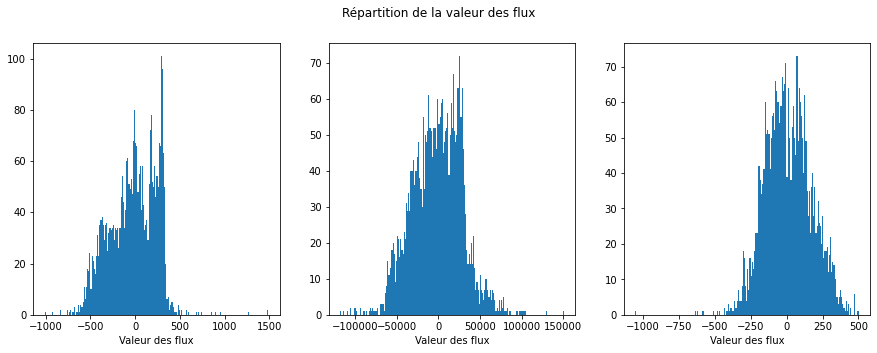

In [20]:
# labels_1=[34,26,0]

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(train_data.iloc[34,:], bins=200)
ax[1].hist(train_data.iloc[26,:], bins=200)
ax[2].hist(train_data.iloc[0,:], bins=200)

ax[0].set_xlabel("Valeur des flux")
ax[1].set_xlabel("Valeur des flux")
ax[2].set_xlabel("Valeur des flux")
fig.suptitle("Répartition de la valeur des flux")

plt.show()

#### A l'inverses des étoiles n'ayant pas d'exoplanètes, on observe ici une importante variation de l'intensité lumineuse

### Préparation des données

#### On convertit les valeurs du Label en binaire pour faciliter le traitement des données

In [21]:
label_change = {1: 0,2: 1}
train_data.LABEL = [label_change[item] for item in train_data.LABEL]
test_data.LABEL = [label_change[item] for item in test_data.LABEL]

In [22]:
train_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,0,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,0,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,0,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [23]:
test_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,1,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,1,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,1,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,1,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,0,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,0,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,0,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60


### On a pu remarquer des anomalies dans les données (les flux), on peut donc essayer de visualiser cela avec des boites à moustache

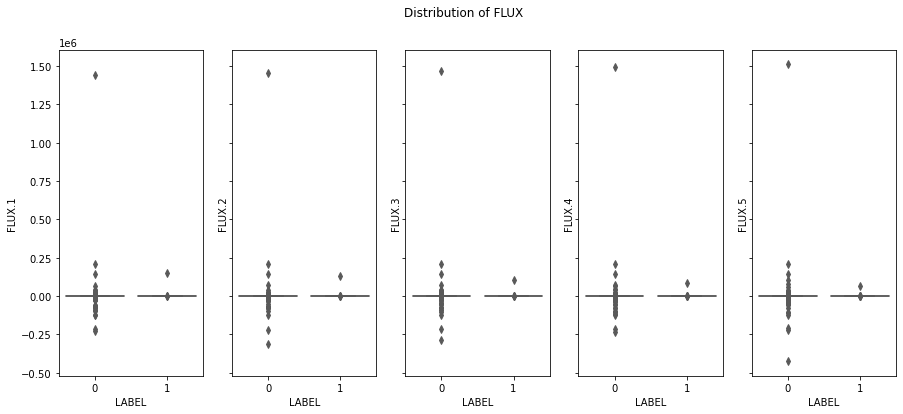

In [24]:
fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1',palette="Set2")
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.2',palette="Set2")
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.3',palette="Set2")
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.4',palette="Set2")
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.5',palette="Set2")

#### On remarque donc des anomalies (des outliers), notamment pour les étoiles ne possédant pas d'exoplanetes, que l'on va retirer car ils peuvent perturber l'apprentissage du model plus tard

#### Retrait des anomalies (outliers)

In [25]:
def remove_outliers(df):
    for col in df.columns:
        print("capping the ",col)
        if (col != 'LABEL'):
            percentiles = df[col].quantile([0.02,0.98]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df
    

final = remove_outliers(train_data)

capping the  LABEL
capping the  FLUX.1
capping the  FLUX.2
capping the  FLUX.3
capping the  FLUX.4
capping the  FLUX.5
capping the  FLUX.6
capping the  FLUX.7
capping the  FLUX.8
capping the  FLUX.9
capping the  FLUX.10
capping the  FLUX.11
capping the  FLUX.12
capping the  FLUX.13
capping the  FLUX.14
capping the  FLUX.15
capping the  FLUX.16
capping the  FLUX.17
capping the  FLUX.18
capping the  FLUX.19
capping the  FLUX.20
capping the  FLUX.21
capping the  FLUX.22
capping the  FLUX.23
capping the  FLUX.24
capping the  FLUX.25
capping the  FLUX.26
capping the  FLUX.27
capping the  FLUX.28
capping the  FLUX.29
capping the  FLUX.30
capping the  FLUX.31
capping the  FLUX.32
capping the  FLUX.33
capping the  FLUX.34
capping the  FLUX.35
capping the  FLUX.36
capping the  FLUX.37
capping the  FLUX.38
capping the  FLUX.39
capping the  FLUX.40
capping the  FLUX.41
capping the  FLUX.42
capping the  FLUX.43
capping the  FLUX.44
capping the  FLUX.45
capping the  FLUX.46
capping the 

C:\Users\beren\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\beren\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


 FLUX.47
capping the  FLUX.48
capping the  FLUX.49
capping the  FLUX.50
capping the  FLUX.51
capping the  FLUX.52
capping the  FLUX.53
capping the  FLUX.54
capping the  FLUX.55
capping the  FLUX.56
capping the  FLUX.57
capping the  FLUX.58
capping the  FLUX.59
capping the  FLUX.60
capping the  FLUX.61
capping the  FLUX.62
capping the  FLUX.63
capping the  FLUX.64
capping the  FLUX.65
capping the  FLUX.66
capping the  FLUX.67
capping the  FLUX.68
capping the  FLUX.69
capping the  FLUX.70
capping the  FLUX.71
capping the  FLUX.72
capping the  FLUX.73
capping the  FLUX.74
capping the  FLUX.75
capping the  FLUX.76
capping the  FLUX.77
capping the  FLUX.78
capping the  FLUX.79
capping the  FLUX.80
capping the  FLUX.81
capping the  FLUX.82
capping the  FLUX.83
capping the  FLUX.84
capping the  FLUX.85
capping the  FLUX.86
capping the  FLUX.87
capping the  FLUX.88
capping the  FLUX.89
capping the  FLUX.90
capping the  FLUX.91
capping the  FLUX.92
capping the  FLUX.93
capping the  FLUX.94
capp

capping the  FLUX.468
capping the  FLUX.469
capping the  FLUX.470
capping the  FLUX.471
capping the  FLUX.472
capping the  FLUX.473
capping the  FLUX.474
capping the  FLUX.475
capping the  FLUX.476
capping the  FLUX.477
capping the  FLUX.478
capping the  FLUX.479
capping the  FLUX.480
capping the  FLUX.481
capping the  FLUX.482
capping the  FLUX.483
capping the  FLUX.484
capping the  FLUX.485
capping the  FLUX.486
capping the  FLUX.487
capping the  FLUX.488
capping the  FLUX.489
capping the  FLUX.490
capping the  FLUX.491
capping the  FLUX.492
capping the  FLUX.493
capping the  FLUX.494
capping the  FLUX.495
capping the  FLUX.496
capping the  FLUX.497
capping the  FLUX.498
capping the  FLUX.499
capping the  FLUX.500
capping the  FLUX.501
capping the  FLUX.502
capping the  FLUX.503
capping the  FLUX.504
capping the  FLUX.505
capping the  FLUX.506
capping the  FLUX.507
capping the  FLUX.508
capping the  FLUX.509
capping the  FLUX.510
capping the  FLUX.511
capping the  FLUX.512
capping th

capping the  FLUX.859
capping the  FLUX.860
capping the  FLUX.861
capping the  FLUX.862
capping the  FLUX.863
capping the  FLUX.864
capping the  FLUX.865
capping the  FLUX.866
capping the  FLUX.867
capping the  FLUX.868
capping the  FLUX.869
capping the  FLUX.870
capping the  FLUX.871
capping the  FLUX.872
capping the  FLUX.873
capping the  FLUX.874
capping the  FLUX.875
capping the  FLUX.876
capping the  FLUX.877
capping the  FLUX.878
capping the  FLUX.879
capping the  FLUX.880
capping the  FLUX.881
capping the  FLUX.882
capping the  FLUX.883
capping the  FLUX.884
capping the  FLUX.885
capping the  FLUX.886
capping the  FLUX.887
capping the  FLUX.888
capping the  FLUX.889
capping the  FLUX.890
capping the  FLUX.891
capping the  FLUX.892
capping the  FLUX.893
capping the  FLUX.894
capping the  FLUX.895
capping the  FLUX.896
capping the  FLUX.897
capping the  FLUX.898
capping the  FLUX.899
capping the  FLUX.900
capping the  FLUX.901
capping the  FLUX.902
capping the  FLUX.903
capping th

capping the  FLUX.1248
capping the  FLUX.1249
capping the  FLUX.1250
capping the  FLUX.1251
capping the  FLUX.1252
capping the  FLUX.1253
capping the  FLUX.1254
capping the  FLUX.1255
capping the  FLUX.1256
capping the  FLUX.1257
capping the  FLUX.1258
capping the  FLUX.1259
capping the  FLUX.1260
capping the  FLUX.1261
capping the  FLUX.1262
capping the  FLUX.1263
capping the  FLUX.1264
capping the  FLUX.1265
capping the  FLUX.1266
capping the  FLUX.1267
capping the  FLUX.1268
capping the  FLUX.1269
capping the  FLUX.1270
capping the  FLUX.1271
capping the  FLUX.1272
capping the  FLUX.1273
capping the  FLUX.1274
capping the  FLUX.1275
capping the  FLUX.1276
capping the  FLUX.1277
capping the  FLUX.1278
capping the  FLUX.1279
capping the  FLUX.1280
capping the  FLUX.1281
capping the  FLUX.1282
capping the  FLUX.1283
capping the  FLUX.1284
capping the  FLUX.1285
capping the  FLUX.1286
capping the  FLUX.1287
capping the  FLUX.1288
capping the  FLUX.1289
capping the  FLUX.1290
capping the

capping the  FLUX.1605
capping the  FLUX.1606
capping the  FLUX.1607
capping the  FLUX.1608
capping the  FLUX.1609
capping the  FLUX.1610
capping the  FLUX.1611
capping the  FLUX.1612
capping the  FLUX.1613
capping the  FLUX.1614
capping the  FLUX.1615
capping the  FLUX.1616
capping the  FLUX.1617
capping the  FLUX.1618
capping the  FLUX.1619
capping the  FLUX.1620
capping the  FLUX.1621
capping the  FLUX.1622
capping the  FLUX.1623
capping the  FLUX.1624
capping the  FLUX.1625
capping the  FLUX.1626
capping the  FLUX.1627
capping the  FLUX.1628
capping the  FLUX.1629
capping the  FLUX.1630
capping the  FLUX.1631
capping the  FLUX.1632
capping the  FLUX.1633
capping the  FLUX.1634
capping the  FLUX.1635
capping the  FLUX.1636
capping the  FLUX.1637
capping the  FLUX.1638
capping the  FLUX.1639
capping the  FLUX.1640
capping the  FLUX.1641
capping the  FLUX.1642
capping the  FLUX.1643
capping the  FLUX.1644
capping the  FLUX.1645
capping the  FLUX.1646
capping the  FLUX.1647
capping the

capping the  FLUX.1986
capping the  FLUX.1987
capping the  FLUX.1988
capping the  FLUX.1989
capping the  FLUX.1990
capping the  FLUX.1991
capping the  FLUX.1992
capping the  FLUX.1993
capping the  FLUX.1994
capping the  FLUX.1995
capping the  FLUX.1996
capping the  FLUX.1997
capping the  FLUX.1998
capping the  FLUX.1999
capping the  FLUX.2000
capping the  FLUX.2001
capping the  FLUX.2002
capping the  FLUX.2003
capping the  FLUX.2004
capping the  FLUX.2005
capping the  FLUX.2006
capping the  FLUX.2007
capping the  FLUX.2008
capping the  FLUX.2009
capping the  FLUX.2010
capping the  FLUX.2011
capping the  FLUX.2012
capping the  FLUX.2013
capping the  FLUX.2014
capping the  FLUX.2015
capping the  FLUX.2016
capping the  FLUX.2017
capping the  FLUX.2018
capping the  FLUX.2019
capping the  FLUX.2020
capping the  FLUX.2021
capping the  FLUX.2022
capping the  FLUX.2023
capping the  FLUX.2024
capping the  FLUX.2025
capping the  FLUX.2026
capping the  FLUX.2027
capping the  FLUX.2028
capping the

capping the  FLUX.2373
capping the  FLUX.2374
capping the  FLUX.2375
capping the  FLUX.2376
capping the  FLUX.2377
capping the  FLUX.2378
capping the  FLUX.2379
capping the  FLUX.2380
capping the  FLUX.2381
capping the  FLUX.2382
capping the  FLUX.2383
capping the  FLUX.2384
capping the  FLUX.2385
capping the  FLUX.2386
capping the  FLUX.2387
capping the  FLUX.2388
capping the  FLUX.2389
capping the  FLUX.2390
capping the  FLUX.2391
capping the  FLUX.2392
capping the  FLUX.2393
capping the  FLUX.2394
capping the  FLUX.2395
capping the  FLUX.2396
capping the  FLUX.2397
capping the  FLUX.2398
capping the  FLUX.2399
capping the  FLUX.2400
capping the  FLUX.2401
capping the  FLUX.2402
capping the  FLUX.2403
capping the  FLUX.2404
capping the  FLUX.2405
capping the  FLUX.2406
capping the  FLUX.2407
capping the  FLUX.2408
capping the  FLUX.2409
capping the  FLUX.2410
capping the  FLUX.2411
capping the  FLUX.2412
capping the  FLUX.2413
capping the  FLUX.2414
capping the  FLUX.2415
capping the

capping the  FLUX.2759
capping the  FLUX.2760
capping the  FLUX.2761
capping the  FLUX.2762
capping the  FLUX.2763
capping the  FLUX.2764
capping the  FLUX.2765
capping the  FLUX.2766
capping the  FLUX.2767
capping the  FLUX.2768
capping the  FLUX.2769
capping the  FLUX.2770
capping the  FLUX.2771
capping the  FLUX.2772
capping the  FLUX.2773
capping the  FLUX.2774
capping the  FLUX.2775
capping the  FLUX.2776
capping the  FLUX.2777
capping the  FLUX.2778
capping the  FLUX.2779
capping the  FLUX.2780
capping the  FLUX.2781
capping the  FLUX.2782
capping the  FLUX.2783
capping the  FLUX.2784
capping the  FLUX.2785
capping the  FLUX.2786
capping the  FLUX.2787
capping the  FLUX.2788
capping the  FLUX.2789
capping the  FLUX.2790
capping the  FLUX.2791
capping the  FLUX.2792
capping the  FLUX.2793
capping the  FLUX.2794
capping the  FLUX.2795
capping the  FLUX.2796
capping the  FLUX.2797
capping the  FLUX.2798
capping the  FLUX.2799
capping the  FLUX.2800
capping the  FLUX.2801
capping the

capping the  FLUX.3146
capping the  FLUX.3147
capping the  FLUX.3148
capping the  FLUX.3149
capping the  FLUX.3150
capping the  FLUX.3151
capping the  FLUX.3152
capping the  FLUX.3153
capping the  FLUX.3154
capping the  FLUX.3155
capping the  FLUX.3156
capping the  FLUX.3157
capping the  FLUX.3158
capping the  FLUX.3159
capping the  FLUX.3160
capping the  FLUX.3161
capping the  FLUX.3162
capping the  FLUX.3163
capping the  FLUX.3164
capping the  FLUX.3165
capping the  FLUX.3166
capping the  FLUX.3167
capping the  FLUX.3168
capping the  FLUX.3169
capping the  FLUX.3170
capping the  FLUX.3171
capping the  FLUX.3172
capping the  FLUX.3173
capping the  FLUX.3174
capping the  FLUX.3175
capping the  FLUX.3176
capping the  FLUX.3177
capping the  FLUX.3178
capping the  FLUX.3179
capping the  FLUX.3180
capping the  FLUX.3181
capping the  FLUX.3182
capping the  FLUX.3183
capping the  FLUX.3184
capping the  FLUX.3185
capping the  FLUX.3186
capping the  FLUX.3187
capping the  FLUX.3188
capping the

##### on retire les 2% des valeurs les plus hautes et les plus basses pour les remplacer par les valeurs les plus proches

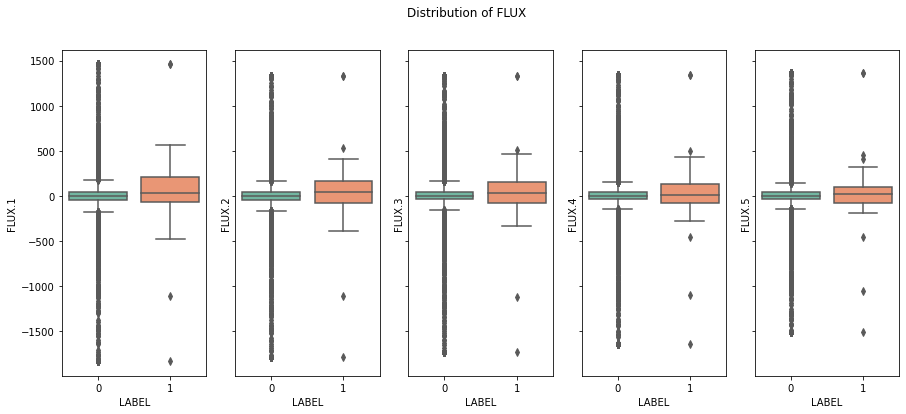

In [26]:
fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1',palette="Set2")
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.2',palette="Set2")
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.3',palette="Set2")
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.4',palette="Set2")
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.5',palette="Set2")

##### On affiche la moyenne de variation lumineuse des étoiles possédant une ou des exoplanète(s)

In [27]:
train_data.loc[train_data['LABEL'] == 1].std(axis=1).mean()

231.22349548241382

##### On affiche la moyenne de variation lumineuse des étoiles ne possédant pas d'exoplanètes

In [28]:
train_data.loc[train_data['LABEL'] == 0].std(axis=1).mean()

122.93167610334919

In [29]:
show = train_data_2[7:8].copy()

In [30]:
show = show.T
show = show[1:-1]

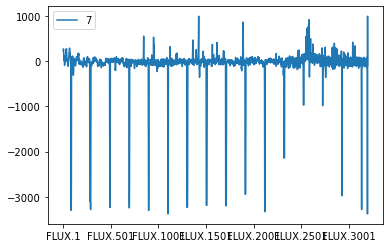

In [31]:
ax2 = show.plot()

In [32]:
show3 = train_data[28:29].copy()

In [33]:
show3 = show3.T
show3 = show3[1:-1]

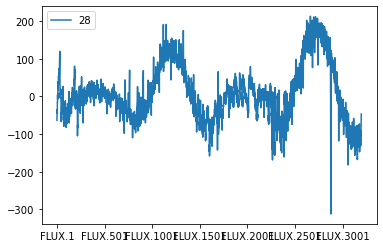

In [34]:
ax2 = show3.plot()

In [35]:
show4 = train_data[100:101].copy()
# show
show4 = show4.T
show4 = show4[1:-1]

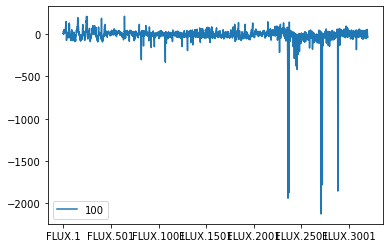

In [36]:
ax2 = show4.plot()

In [37]:
show2 = train_data[5085:-1].copy()
# show
show2 = show2.T
show2 = show2[1:-1]

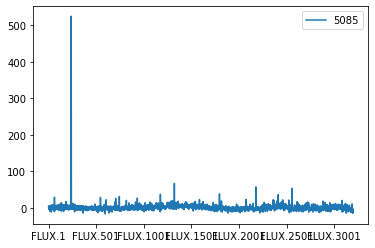

In [38]:

ax2 = show2.plot()

#### On observe que la variation lumineuse des étoiles possédant des exoplanètes est 2 fois plus importante

### On va split le dataset pour travailler dessus et pouvoir préparer le model

In [39]:
X_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
X_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

### Normalisation de la donnée

#### On va normaliser les données pour la préparer pour le machine learning. L'idée est d'organiser toutes les données dans un même fourchette pour faciliter l'apprentissage (tout en gardant les ordres de grandeur)

In [40]:
X_train = normalize(X_train)
X_test = normalize(X_test)

### Feature scaling

In [41]:
std_scaler = StandardScaler()
X_train = scaled = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

# On définit les modèles qu'on va utiliser

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Test d'algorithme

### Decision Tree

In [43]:
model_DT = DecisionTreeClassifier(max_features=4, random_state=0)

In [44]:
model_DT.fit(X_train, y_train)
print(model_DT.__class__.__name__, model_DT.score(X_test, y_test))
print(confusion_matrix(y_test, model_DT.predict(X_test)))

DecisionTreeClassifier 0.9824561403508771
[[560   5]
 [  5   0]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

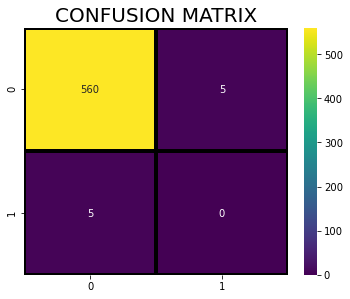

In [45]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_DT.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

### RandomForest

In [46]:
model_RF = RandomForestClassifier(n_estimators=10, max_features=5,  n_jobs=-1)

In [47]:
model_RF.fit(X_train, y_train)
print(model_RF.__class__.__name__, model_RF.score(X_test, y_test))
print(confusion_matrix(y_test, model_RF.predict(X_test)))

RandomForestClassifier 0.9912280701754386
[[565   0]
 [  5   0]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

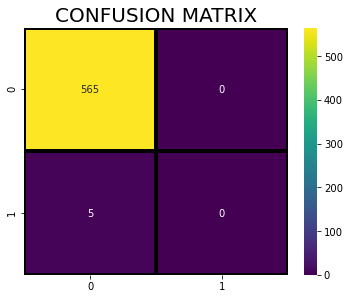

In [48]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_RF.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

###  On arrive pas ou très difficilement à déterminer si une étoile possède des planètes

### Nous sommes en présent d'un accuracy paradox dû au déséquilibre des données

### Comme on l'a vu, l'échantillon est très déséquilibré. On va tenter de rééquilibrer les 2 catégories grâce à un SMOTE pour faciliter l'apprentissage.

## SMOTE

In [49]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [50]:
smote = SMOTE(random_state=1)
train_X, train_y = smote.fit_sample(train_data.drop('LABEL',axis=1), train_data['LABEL'])

In [51]:
train_X

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.850000,83.810000,20.100000,-26.980000,-39.560000,-124.710000,-135.180000,-96.270000,-79.890000,-160.170000,...,-78.070000,-102.150000,-102.150000,25.130000,48.570000,92.540000,39.320000,61.420000,5.080000,-39.540000
1,-38.880000,-33.830000,-58.540000,-40.090000,-79.310000,-72.810000,-86.550000,-85.330000,-83.970000,-73.380000,...,-3.280000,-32.210000,-32.210000,-24.890000,-4.860000,0.760000,-11.700000,6.460000,16.000000,19.930000
2,532.640000,535.920000,513.730000,496.920000,456.450000,466.000000,464.500000,486.390000,436.560000,484.390000,...,-71.690000,13.310000,13.310000,-29.890000,-20.880000,5.060000,-11.800000,-28.910000,-70.020000,-96.670000
3,326.520000,347.390000,302.350000,298.130000,317.740000,312.700000,322.330000,311.310000,312.420000,323.330000,...,5.710000,-3.730000,-3.730000,30.050000,20.030000,-12.670000,-8.770000,-17.310000,-17.350000,13.980000
4,-1107.210000,-1112.590000,-1118.950000,-1095.100000,-1057.550000,-1034.480000,-998.340000,-1022.710000,-989.570000,-970.880000,...,-594.370000,-401.660000,-401.660000,-357.240000,-443.760000,-438.540000,-399.710000,-384.650000,-411.790000,-510.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,-37.762407,-28.610902,-40.350344,-33.142900,-19.153846,-13.976410,-16.842233,-7.074976,-17.221413,6.051566,...,5.469546,-38.654270,-26.475028,-36.629695,-41.661984,-18.543197,-13.295111,-6.905054,1.751265,11.388910
10096,-120.004065,-117.907992,-127.523213,-107.195438,-108.064381,-94.869455,-92.208152,-84.369956,-73.075914,-59.126073,...,21.454404,-40.369773,-40.369773,-42.459509,-54.562003,-53.365841,-36.848303,-24.094639,11.504370,-4.465667
10097,-112.220865,-112.170388,-121.156759,-100.354635,-100.977444,-86.632390,-85.336096,-76.049112,-65.798173,-51.494164,...,21.188318,-41.670656,-41.670656,-46.175459,-55.715523,-53.337255,-36.740186,-24.794328,12.066986,-7.208281
10098,52.866006,58.044512,41.450882,59.999963,34.929451,38.189835,23.149620,27.512235,22.777153,13.410216,...,34.326297,-1.050533,20.141804,-10.788668,-10.071694,8.715645,-5.010329,-10.815657,-1.900401,-13.017458


In [52]:
train_y

0        1
1        1
2        1
3        1
4        1
        ..
10095    1
10096    1
10097    1
10098    1
10099    1
Name: LABEL, Length: 10100, dtype: int64

In [53]:
train_y

0        1
1        1
2        1
3        1
4        1
        ..
10095    1
10096    1
10097    1
10098    1
10099    1
Name: LABEL, Length: 10100, dtype: int64

Text(0.5, 1.0, 'Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)')

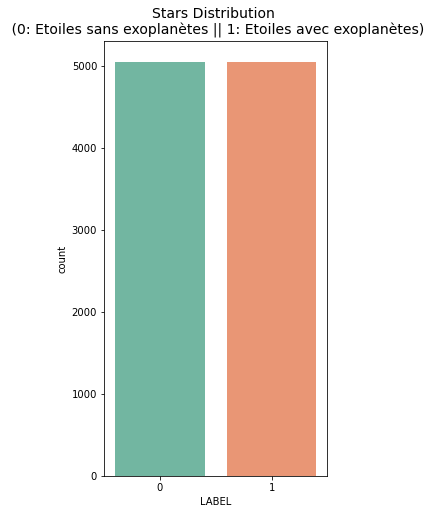

In [54]:
plt.figure(figsize=(4,8))
colors = ["0", "1"]
sns.countplot(x=train_y, palette = "Set2")
plt.title('Stars Distribution \n (0: Etoiles sans exoplanètes || 1: Etoiles avec exoplanètes)', fontsize=14)

### On normalize et on scale

In [55]:
train_X = normalize(train_X)

In [56]:
std_scaler = StandardScaler()
train_X = scaled = std_scaler.fit_transform(train_X)

In [57]:
from sklearn.model_selection import train_test_split 

In [58]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.1, random_state=42, stratify=train_y)

In [59]:
train_y.value_counts(normalize=True)

1    0.5
0    0.5
Name: LABEL, dtype: float64

### Maintenant qu'on a rééquilibré le data set on va pouvoir re-tester

## Decision Tree

In [60]:
model_DT_SMOTE = DecisionTreeClassifier(max_features=200, random_state=1)

In [61]:
model_DT_SMOTE.fit(train_X, train_y)
print(model_DT_SMOTE.__class__.__name__, model_DT_SMOTE.score(test_X, test_y))
print(confusion_matrix(test_y, model_DT_SMOTE.predict(test_X)))

DecisionTreeClassifier 0.9881188118811881
[[494  11]
 [  1 504]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

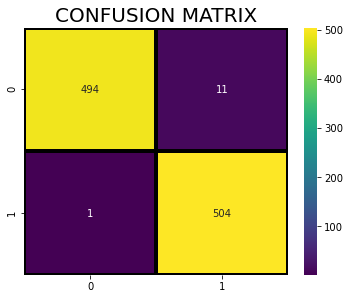

In [62]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,model_DT_SMOTE.predict(test_X)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## KNN

In [63]:
model_KNN_SMOTE = KNeighborsClassifier(n_neighbors=5, metric='manhattan', n_jobs=-1)

In [64]:
model_KNN_SMOTE.fit(train_X, train_y)
print(model_KNN_SMOTE.__class__.__name__, model_KNN_SMOTE.score(test_X, test_y))
print(confusion_matrix(test_y, model_KNN_SMOTE.predict(test_X)))

KNeighborsClassifier 0.995049504950495
[[500   5]
 [  0 505]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

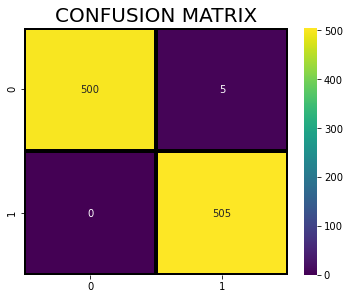

In [65]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,model_KNN_SMOTE.predict(test_X)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Random Forest

In [66]:
model_RF_SMOTE = RandomForestClassifier(n_estimators=10, max_features=5,  n_jobs=-1)

In [67]:
model_RF_SMOTE = model_RF_SMOTE.fit(train_X, train_y)
print(model_RF_SMOTE.__class__.__name__, model_RF_SMOTE.score(test_X, test_y))
print(confusion_matrix(test_y, model_RF_SMOTE.predict(test_X)))

RandomForestClassifier 0.998019801980198
[[505   0]
 [  2 503]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

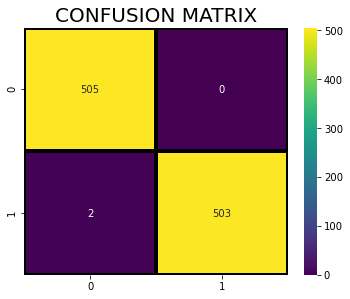

In [68]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,model_RF_SMOTE.predict(test_X)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

## Logistic Regression

In [69]:
model_LR_SMOTE = LogisticRegression(solver='lbfgs', max_iter=1000)

In [70]:
model_LR_SMOTE.fit(train_X, train_y)
print(model_LR_SMOTE.__class__.__name__, model_LR_SMOTE.score(test_X, test_y))
print(confusion_matrix(test_y, model_LR_SMOTE.predict(test_X)))

LogisticRegression 0.999009900990099
[[504   1]
 [  0 505]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

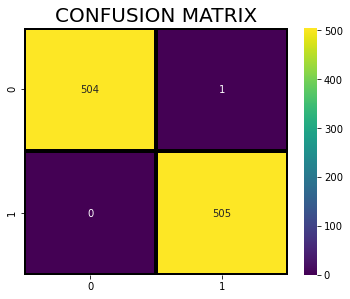

In [71]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,model_LR_SMOTE.predict(test_X)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

In [72]:
y_pred = model_RF_SMOTE.predict(test_X)

In [73]:
f1_score(test_y, y_pred, zero_division=1)

0.998015873015873

In [74]:
# predict
# rfc_predict = rfc.predict(x_test)# check performance
print('ROCAUC score:',roc_auc_score(test_y, y_pred))
print('Accuracy score:',accuracy_score(test_y, y_pred))
# print('Recall score:',recall_score(test_y, y_pred))
print('F1 score:',f1_score(test_y, y_pred))



ROCAUC score: 0.998019801980198
Accuracy score: 0.998019801980198
F1 score: 0.998015873015873


In [75]:
model_RF_SMOTE.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Text(0.5, 1.0, 'CONFUSION MATRIX')

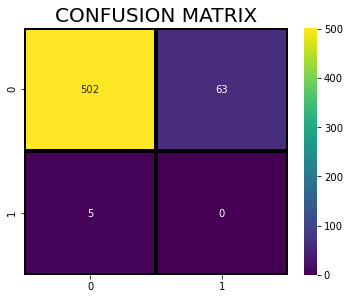

In [76]:
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_DT_SMOTE.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

In [77]:
y_pred2 = model_DT_SMOTE.predict(X_test)

In [78]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred2))
print('Accuracy score:',accuracy_score(y_test, y_pred2))
print('Recall score:',recall_score(y_test, y_pred2))
print('F1 score:',f1_score(y_test, y_pred2))

ROCAUC score: 0.44424778761061945
Accuracy score: 0.8807017543859649
Recall score: 0.0
F1 score: 0.0


## Tests de prédiction

In [79]:
from astropy.io import fits
from astropy.table import Table

In [80]:
dat = Table.read('data/data_fits/ktwo200004472-c03_llc.fits', format='fits')
df = dat.to_pandas()

In [81]:
df

,TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
0,2144.103211,0.005430,99599,146.221802,11.055656,15181.249023,7.789165,NaN,NaN,524288,NaN,NaN,NaN,NaN,98.0,0.000000e+00,846.666001,0.866056,0.054567,-0.023578
1,2144.123644,0.005429,99600,262.896362,11.080358,15185.769531,7.823909,205.686035,10.926676,0,NaN,NaN,NaN,NaN,98.0,0.000000e+00,844.128962,0.465236,0.053394,-0.016367
2,2144.144076,0.005428,99601,252.297546,11.040573,15184.875977,7.767826,194.782089,10.897986,0,NaN,NaN,NaN,NaN,98.0,0.000000e+00,844.348792,0.485709,0.053131,-0.017073
3,2144.164508,0.005427,99602,252.809479,11.022403,15205.670898,7.741865,195.141739,10.877254,0,NaN,NaN,NaN,NaN,98.0,0.000000e+00,844.898574,0.487614,0.049095,-0.006122
4,2144.184940,0.005425,99603,311.507812,11.070071,15175.075195,7.808357,254.074524,10.935021,0,NaN,NaN,NaN,NaN,98.0,3.613213e-16,846.563383,0.405918,0.049736,-0.010472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3381,2213.182933,-0.000863,102980,-61.443558,12.010972,31733.230469,8.421459,NaN,NaN,1048576,NaN,NaN,NaN,NaN,98.0,1.998777e-15,827.206839,2.993605,-0.026252,-0.003375
3382,2213.203364,-0.000865,102981,-16.640005,12.053338,31724.158203,8.480641,-2.892987,12.003874,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.021225,-0.007596
3383,2213.223796,-0.000867,102982,-32.457165,12.058466,31757.740234,8.488002,-17.970291,12.010014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027310,0.001112
3384,2213.244227,-0.000869,102983,-44.022972,12.078589,31764.359375,8.515874,-30.030788,12.033045,0,NaN,NaN,NaN,NaN,98.0,0.000000e+00,816.506501,5.839766,-0.029850,0.011370


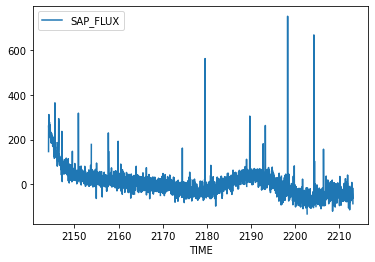

In [146]:
ax2 = df.plot(x='TIME', y='SAP_FLUX')

### On affiche le FLUX de l'étoile

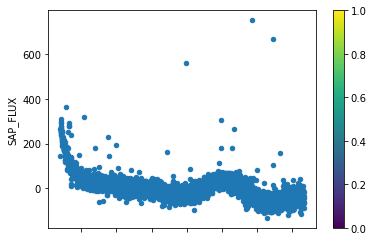

In [82]:
ax2 = df.plot.scatter(x='TIME',
                      y='SAP_FLUX',
                      colormap='viridis')

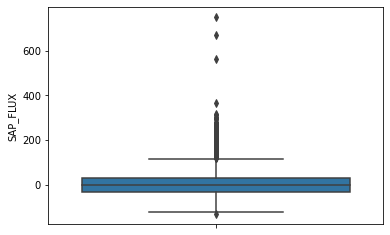

In [84]:
fig.suptitle('Distribution of FLUX')

sns.boxplot(y=df["SAP_FLUX"])


In [85]:
def transform_to_df(data):
    data_df = []
    
    for ind in data.index:
        data_df.append(data['SAP_FLUX'][ind])

    df = pd.DataFrame(data_df)
        
    shape = df.shape

    if shape[0] != 1:
        df = df.T  
        
    return df

In [86]:
def prepare_data(df):

#     si ce sont des données récupérées des fichiers fits on les transforme pour avoir le format souhaité
    if 'SAP_FLUX' in df.columns:
        df = transform_to_df(df)

    df = df.dropna(axis=1)
    
    
    if(df.size < 3197):
        print("Pas assez de donnéees")
        return None
    else:
        print("Assez de donnéees, traitement en cours ....")
        
#         shape = df_test.shape
#         if shape[0] != 1 :
#             df_test_swap = df_test.T
#         else:
#             df_test_swap = df_test
            
            
        df = remove_outliers(df)
        
        df_normalized = normalize(df)
        
        std_scaler = StandardScaler()
        df_normalized_scalled = scaled = std_scaler.fit_transform(df_normalized)
        
        df_transformed = pd.DataFrame(df_normalized_scalled) 
#         df_transformed = pd.DataFrame(df) 
    
        if df_transformed.size > 3197:
            df_final = df_transformed[df_transformed.columns[0:3197]]
    
        print("Traitement terminé")
        return df_final

In [87]:
def isexoplanet(model, df):
#     x = np.array(df[0]).reshape(1,3197)
    x = np.array(df).reshape(1, -1)
    
    print(model.predict(x))
    if model.predict(x) == 1:
        print("Cette étoile possède des exoplanètes")
    elif model.predict(x) == 0:
        print("Cette étoile ne possède pas d'exoplanètes")
        
    print(model.predict_proba(x))

### Un exemple de predict avec et sans exoplanetes

In [88]:
df['SAP_FLUX']

0       146.221802
1       262.896362
2       252.297546
3       252.809479
4       311.507812
           ...    
3381    -61.443558
3382    -16.640005
3383    -32.457165
3384    -44.022972
3385    -86.721535
Name: SAP_FLUX, Length: 3386, dtype: float32

In [89]:
test = prepare_data(df)

Assez de donnéees, traitement en cours ....
capping the  0
capping the  1
capping the  2
capping the  3
capping the  4
capping the  5
capping the  6
capping the  7
capping the  8
capping the  9
capping the  10
capping the  11
capping the  12
capping the  13
capping the  14
capping the  15
capping the  16
capping the  17
capping the  18
capping the  19
capping the  20
capping the  21
capping the  22
capping the  23
capping the  24
capping the  25
capping the  26
capping the  27
capping the  28
capping the  29
capping the  30
capping the  31
capping the  32
capping the  33
capping the  34
capping the  35
capping the  36
capping the  37
capping the  38
capping the  39
capping the  40
capping the  41
capping the  42
capping the  43
capping the  44
capping the  45
capping the  46
capping the  47
capping the  48
capping the  49
capping the  50
capping the  51
capping the  52
capping the  53
capping the  54
capping the  55
capping the  56
capping the  57
capping the  58
capping the  59
cappin

capping the  492
capping the  493
capping the  494
capping the  495
capping the  496
capping the  497
capping the  498
capping the  499
capping the  500
capping the  501
capping the  502
capping the  503
capping the  504
capping the  505
capping the  506
capping the  507
capping the  508
capping the  509
capping the  510
capping the  511
capping the  512
capping the  513
capping the  514
capping the  515
capping the  516
capping the  517
capping the  518
capping the  519
capping the  520
capping the  521
capping the  522
capping the  523
capping the  524
capping the  525
capping the  526
capping the  527
capping the  528
capping the  529
capping the  530
capping the  531
capping the  532
capping the  533
capping the  534
capping the  535
capping the  536
capping the  537
capping the  538
capping the  539
capping the  540
capping the  541
capping the  542
capping the  543
capping the  544
capping the  545
capping the  546
capping the  547
capping the  548
capping the  549
capping the  5

capping the  1044
capping the  1045
capping the  1046
capping the  1047
capping the  1048
capping the  1049
capping the  1050
capping the  1051
capping the  1052
capping the  1054
capping the  1055
capping the  1056
capping the  1057
capping the  1058
capping the  1059
capping the  1060
capping the  1061
capping the  1062
capping the  1063
capping the  1064
capping the  1065
capping the  1066
capping the  1067
capping the  1068
capping the  1069
capping the  1070
capping the  1071
capping the  1072
capping the  1073
capping the  1074
capping the  1075
capping the  1076
capping the  1077
capping the  1078
capping the  1079
capping the  1080
capping the  1081
capping the  1082
capping the  1083
capping the  1084
capping the  1085
capping the  1086
capping the  1087
capping the  1088
capping the  1089
capping the  1090
capping the  1091
capping the  1092
capping the  1093
capping the  1094
capping the  1095
capping the  1096
capping the  1097
capping the  1098
capping the  1099
capping th

capping the  1538
capping the  1539
capping the  1540
capping the  1541
capping the  1542
capping the  1543
capping the  1544
capping the  1545
capping the  1546
capping the  1547
capping the  1548
capping the  1549
capping the  1550
capping the  1551
capping the  1552
capping the  1553
capping the  1554
capping the  1555
capping the  1556
capping the  1557
capping the  1558
capping the  1559
capping the  1560
capping the  1561
capping the  1562
capping the  1563
capping the  1564
capping the  1565
capping the  1566
capping the  1567
capping the  1568
capping the  1569
capping the  1570
capping the  1571
capping the  1572
capping the  1573
capping the  1574
capping the  1575
capping the  1576
capping the  1577
capping the  1578
capping the  1579
capping the  1580
capping the  1581
capping the  1582
capping the  1583
capping the  1584
capping the  1585
capping the  1586
capping the  1587
capping the  1588
capping the  1589
capping the  1590
capping the  1591
capping the  1592
capping th

capping the  2007
capping the  2008
capping the  2009
capping the  2010
capping the  2011
capping the  2012
capping the  2014
capping the  2015
capping the  2016
capping the  2017
capping the  2018
capping the  2019
capping the  2020
capping the  2021
capping the  2022
capping the  2023
capping the  2024
capping the  2025
capping the  2026
capping the  2027
capping the  2028
capping the  2029
capping the  2030
capping the  2031
capping the  2032
capping the  2033
capping the  2034
capping the  2035
capping the  2036
capping the  2037
capping the  2038
capping the  2039
capping the  2040
capping the  2041
capping the  2042
capping the  2043
capping the  2044
capping the  2045
capping the  2046
capping the  2047
capping the  2048
capping the  2049
capping the  2050
capping the  2051
capping the  2052
capping the  2053
capping the  2054
capping the  2055
capping the  2056
capping the  2057
capping the  2058
capping the  2059
capping the  2060
capping the  2061
capping the  2062
capping th

capping the  2483
capping the  2484
capping the  2485
capping the  2486
capping the  2487
capping the  2488
capping the  2489
capping the  2490
capping the  2491
capping the  2492
capping the  2494
capping the  2495
capping the  2496
capping the  2497
capping the  2498
capping the  2499
capping the  2500
capping the  2501
capping the  2502
capping the  2503
capping the  2504
capping the  2505
capping the  2506
capping the  2507
capping the  2508
capping the  2509
capping the  2510
capping the  2511
capping the  2512
capping the  2513
capping the  2514
capping the  2515
capping the  2516
capping the  2517
capping the  2518
capping the  2519
capping the  2520
capping the  2521
capping the  2522
capping the  2523
capping the  2524
capping the  2525
capping the  2526
capping the  2527
capping the  2528
capping the  2529
capping the  2530
capping the  2531
capping the  2532
capping the  2533
capping the  2534
capping the  2535
capping the  2536
capping the  2537
capping the  2538
capping th

capping the  2965
capping the  2966
capping the  2967
capping the  2968
capping the  2969
capping the  2970
capping the  2971
capping the  2972
capping the  2974
capping the  2975
capping the  2976
capping the  2977
capping the  2978
capping the  2979
capping the  2980
capping the  2981
capping the  2982
capping the  2983
capping the  2984
capping the  2985
capping the  2986
capping the  2987
capping the  2988
capping the  2989
capping the  2990
capping the  2991
capping the  2992
capping the  2993
capping the  2994
capping the  2995
capping the  2996
capping the  2997
capping the  2998
capping the  2999
capping the  3000
capping the  3001
capping the  3002
capping the  3003
capping the  3004
capping the  3005
capping the  3006
capping the  3007
capping the  3008
capping the  3009
capping the  3010
capping the  3011
capping the  3012
capping the  3013
capping the  3014
capping the  3015
capping the  3016
capping the  3017
capping the  3018
capping the  3019
capping the  3020
capping th

In [90]:
prepared_data = prepare_data(df)

Assez de donnéees, traitement en cours ....
capping the  0
capping the  1
capping the  2
capping the  3
capping the  4
capping the  5
capping the  6
capping the  7
capping the  8
capping the  9
capping the  10
capping the  11
capping the  12
capping the  13
capping the  14
capping the  15
capping the  16
capping the  17
capping the  18
capping the  19
capping the  20
capping the  21
capping the  22
capping the  23
capping the  24
capping the  25
capping the  26
capping the  27
capping the  28
capping the  29
capping the  30
capping the  31
capping the  32
capping the  33
capping the  34
capping the  35
capping the  36
capping the  37
capping the  38
capping the  39
capping the  40
capping the  41
capping the  42
capping the  43
capping the  44
capping the  45
capping the  46
capping the  47
capping the  48
capping the  49
capping the  50
capping the  51
capping the  52
capping the  53
capping the  54
capping the  55
capping the  56
capping the  57
capping the  58
capping the  59
cappin

capping the  500
capping the  501
capping the  502
capping the  503
capping the  504
capping the  505
capping the  506
capping the  507
capping the  508
capping the  509
capping the  510
capping the  511
capping the  512
capping the  513
capping the  514
capping the  515
capping the  516
capping the  517
capping the  518
capping the  519
capping the  520
capping the  521
capping the  522
capping the  523
capping the  524
capping the  525
capping the  526
capping the  527
capping the  528
capping the  529
capping the  530
capping the  531
capping the  532
capping the  533
capping the  534
capping the  535
capping the  536
capping the  537
capping the  538
capping the  539
capping the  540
capping the  541
capping the  542
capping the  543
capping the  544
capping the  545
capping the  546
capping the  547
capping the  548
capping the  549
capping the  550
capping the  551
capping the  552
capping the  553
capping the  554
capping the  555
capping the  556
capping the  557
capping the  5

capping the  1000
capping the  1001
capping the  1002
capping the  1003
capping the  1004
capping the  1005
capping the  1006
capping the  1007
capping the  1008
capping the  1009
capping the  1010
capping the  1011
capping the  1012
capping the  1013
capping the  1014
capping the  1015
capping the  1016
capping the  1017
capping the  1018
capping the  1019
capping the  1020
capping the  1021
capping the  1022
capping the  1023
capping the  1024
capping the  1025
capping the  1026
capping the  1027
capping the  1028
capping the  1029
capping the  1030
capping the  1031
capping the  1032
capping the  1033
capping the  1034
capping the  1035
capping the  1036
capping the  1037
capping the  1038
capping the  1039
capping the  1040
capping the  1041
capping the  1042
capping the  1043
capping the  1044
capping the  1045
capping the  1046
capping the  1047
capping the  1048
capping the  1049
capping the  1050
capping the  1051
capping the  1052
capping the  1054
capping the  1055
capping th

capping the  1502
capping the  1503
capping the  1504
capping the  1505
capping the  1506
capping the  1507
capping the  1508
capping the  1509
capping the  1510
capping the  1511
capping the  1512
capping the  1513
capping the  1514
capping the  1515
capping the  1516
capping the  1517
capping the  1518
capping the  1519
capping the  1520
capping the  1521
capping the  1522
capping the  1523
capping the  1524
capping the  1525
capping the  1526
capping the  1527
capping the  1528
capping the  1529
capping the  1530
capping the  1531
capping the  1532
capping the  1534
capping the  1535
capping the  1536
capping the  1537
capping the  1538
capping the  1539
capping the  1540
capping the  1541
capping the  1542
capping the  1543
capping the  1544
capping the  1545
capping the  1546
capping the  1547
capping the  1548
capping the  1549
capping the  1550
capping the  1551
capping the  1552
capping the  1553
capping the  1554
capping the  1555
capping the  1556
capping the  1557
capping th

capping the  2004
capping the  2005
capping the  2006
capping the  2007
capping the  2008
capping the  2009
capping the  2010
capping the  2011
capping the  2012
capping the  2014
capping the  2015
capping the  2016
capping the  2017
capping the  2018
capping the  2019
capping the  2020
capping the  2021
capping the  2022
capping the  2023
capping the  2024
capping the  2025
capping the  2026
capping the  2027
capping the  2028
capping the  2029
capping the  2030
capping the  2031
capping the  2032
capping the  2033
capping the  2034
capping the  2035
capping the  2036
capping the  2037
capping the  2038
capping the  2039
capping the  2040
capping the  2041
capping the  2042
capping the  2043
capping the  2044
capping the  2045
capping the  2046
capping the  2047
capping the  2048
capping the  2049
capping the  2050
capping the  2051
capping the  2052
capping the  2053
capping the  2054
capping the  2055
capping the  2056
capping the  2057
capping the  2058
capping the  2059
capping th

capping the  2487
capping the  2488
capping the  2489
capping the  2490
capping the  2491
capping the  2492
capping the  2494
capping the  2495
capping the  2496
capping the  2497
capping the  2498
capping the  2499
capping the  2500
capping the  2501
capping the  2502
capping the  2503
capping the  2504
capping the  2505
capping the  2506
capping the  2507
capping the  2508
capping the  2509
capping the  2510
capping the  2511
capping the  2512
capping the  2513
capping the  2514
capping the  2515
capping the  2516
capping the  2517
capping the  2518
capping the  2519
capping the  2520
capping the  2521
capping the  2522
capping the  2523
capping the  2524
capping the  2525
capping the  2526
capping the  2527
capping the  2528
capping the  2529
capping the  2530
capping the  2531
capping the  2532
capping the  2533
capping the  2534
capping the  2535
capping the  2536
capping the  2537
capping the  2538
capping the  2539
capping the  2540
capping the  2541
capping the  2542
capping th

capping the  2972
capping the  2974
capping the  2975
capping the  2976
capping the  2977
capping the  2978
capping the  2979
capping the  2980
capping the  2981
capping the  2982
capping the  2983
capping the  2984
capping the  2985
capping the  2986
capping the  2987
capping the  2988
capping the  2989
capping the  2990
capping the  2991
capping the  2992
capping the  2993
capping the  2994
capping the  2995
capping the  2996
capping the  2997
capping the  2998
capping the  2999
capping the  3000
capping the  3001
capping the  3002
capping the  3003
capping the  3004
capping the  3005
capping the  3006
capping the  3007
capping the  3008
capping the  3009
capping the  3010
capping the  3011
capping the  3012
capping the  3013
capping the  3014
capping the  3015
capping the  3016
capping the  3017
capping the  3018
capping the  3019
capping the  3020
capping the  3021
capping the  3022
capping the  3023
capping the  3024
capping the  3025
capping the  3026
capping the  3027
capping th

In [91]:
isexoplanet(model_DT_SMOTE, test)

[1]
Cette étoile possède des exoplanètes
[[0. 1.]]


#### test qui doit renvoyer 1

In [92]:
# train_X[1:2]

In [93]:
train_y[1:2]

8335    1
Name: LABEL, dtype: int64

In [94]:
isexoplanet(model_DT_SMOTE, train_X[1:2])

[1]
Cette étoile possède des exoplanètes
[[0. 1.]]


In [95]:
test_y

765     0
3583    0
3680    0
7668    1
3950    0
       ..
2576    0
3457    0
9636    1
5290    1
4896    0
Name: LABEL, Length: 1010, dtype: int64

In [96]:
isexoplanet(model_DT_SMOTE, test_X[1008:1009])

[1]
Cette étoile possède des exoplanètes
[[0. 1.]]


## TESTS

In [97]:
# model_RF_SMOTE.fit(train_X, train_y)
# On voudrait éviter tout en positif

# model_KNN_SMOTE.fit(train_X, train_y)
print(model_DT_SMOTE.__class__.__name__, model_DT_SMOTE.score(X_test, y_test))
print(confusion_matrix(y_test, model_DT_SMOTE.predict(X_test)))

DecisionTreeClassifier 0.8807017543859649
[[502  63]
 [  5   0]]


In [98]:
# train_X/test_X ==> Données du train_test_split après SMOTE
# X_train/X_test ==> Données de bases des fichier


In [99]:
test_X

array([[-0.79331516, -0.79362143, -0.75819361, ..., -1.23585191,
        -1.41047701, -1.19953713],
       [-2.1461098 , -2.12467272, -2.08031514, ...,  0.15487815,
        -0.13269958, -0.24684397],
       [ 0.39764195, -0.77764757, -0.74198037, ...,  0.84116097,
         0.88599906,  0.81408498],
       ...,
       [ 0.39574194,  0.38417139,  0.4544452 , ...,  0.8376225 ,
         0.88312541,  0.80993666],
       [ 0.13260076, -0.00219054, -0.07439131, ..., -0.03520065,
        -0.0838965 , -0.20502716],
       [ 0.05982162,  0.034234  ,  0.02502237, ...,  1.18121827,
         1.28102148,  1.17547604]])

In [100]:
X_test

array([[ 1.66941609,  1.48641482,  1.34280954, ...,  1.48073164,
         5.11125832,  2.15508272],
       [ 1.43716096,  1.53188724,  1.61627926, ..., -1.27924258,
        -0.68004313, -1.04066538],
       [ 3.0440016 ,  3.14120697,  3.10124701, ..., -1.22865225,
        -0.08077967,  0.46754444],
       ...,
       [-1.45439702, -1.25591119, -1.22274475, ...,  0.56562456,
         0.57187439,  1.32685735],
       [ 0.13462753,  0.14689563,  0.07264053, ...,  0.17963185,
         0.07524453,  0.29430559],
       [ 1.57872279,  1.52826714,  1.50418074, ..., -0.13558117,
         0.04556182,  0.35614914]])

#### test qui doit renvoyer 1

In [101]:
smote = SMOTE(random_state=2)
train_X, train_y = smote.fit_sample(train_data.drop('LABEL',axis=1), train_data['LABEL'])

In [102]:
train_X = normalize(train_X)

In [103]:
std_scaler = StandardScaler()
train_X = scaled = std_scaler.fit_transform(train_X)

In [104]:
train_y = pd.DataFrame(train_y)

In [105]:
train_y

,LABEL
0,1
1,1
2,1
3,1
4,1
...,...
10095,1
10096,1
10097,1
10098,1


In [106]:
train_y._get_value(3, 'LABEL') 

1

In [107]:
# from sklearn.model_selection import KFold

# # train_X
# model_KNN_SMOTE = KNeighborsClassifier(n_neighbors=4, metric='manhattan', n_jobs=-1)


# test_data = pd.read_csv('./data/exoTest.csv')
# train_data = pd.read_csv('./data/exoTrain.csv')

# label_change = {1: 0,2: 1}
# test_data.LABEL = [label_change[item] for item in test_data.LABEL]
# train_data.LABEL = [label_change[item] for item in train_data.LABEL]

# X_train = train_data.drop(["LABEL"],axis=1)
# y_train  = train_data["LABEL"]
# X_test = test_data.drop(["LABEL"],axis=1)
# y_test = test_data["LABEL"]

# prepared_train = prepare_data(X_train)
# prepared_test = prepare_data(X_test)


# # prepare cross validation
# kfold = KFold(3, True, 1)

# # enumerate splits
# for train, test in kfold.split(train_X):
    
    
    
#     y_train_kfold = []
#     for item in train:
#         y_train_kfold.append(train_y._get_value(item, 'LABEL') )
        
#     y_test_kfold = []
#     for item in test:
#         y_test_kfold.append(train_y._get_value(item, 'LABEL') )
    
#     model_KNN_SMOTE.fit(train_X[train], y_train_kfold)
    
#     y_pred = model_KNN_SMOTE.predict(prepared_test)
#     print(model_KNN_SMOTE.__class__.__name__, model_KNN_SMOTE.score(train_X[test], y_test_kfold))
#     print(confusion_matrix(y_test_kfold, model_KNN_SMOTE.predict(train_X[test])))
#     plt.figure(figsize=(13,10))
#     plt.subplot(221)
#     sns.heatmap(confusion_matrix(y_test_kfold,model_KNN_SMOTE.predict(prepared_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
#     plt.title("CONFUSION MATRIX",fontsize=20)
#     print(" ")
    
#     print('ROCAUC score:',roc_auc_score(y_test, y_pred))
#     print('Accuracy score:',accuracy_score(y_test, y_pred))
#     print('F1 score:',f1_score(y_test, y_pred))
    
# #     model_KNN_SMOTE.fit(train_X, train_y)
# #     print(model_KNN_SMOTE.__class__.__name__, model_KNN_SMOTE.score(test_X, test_y))
# #     print(confusion_matrix(test_y, model_KNN_SMOTE.predict(test_X)))

In [108]:
# train_X = filtered = ndimage.filters.gaussian_filter(train_X, sigma=0)

In [109]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.1, random_state=42)

In [110]:
# model_KNN_SMOTE = KNeighborsClassifier(n_neighbors=6, metric='manhattan', n_jobs=-1)
model_KNN_SMOTE = KNeighborsClassifier(n_neighbors=4, metric='manhattan', n_jobs=-1)
# model_KNN_SMOTE = KNeighborsClassifier()

In [111]:
model_KNN_SMOTE.fit(train_X, train_y)
print(model_KNN_SMOTE.__class__.__name__, model_KNN_SMOTE.score(test_X, test_y))
print(confusion_matrix(test_y, model_KNN_SMOTE.predict(test_X)))

C:\Users\beren\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


KNeighborsClassifier 0.994059405940594
[[511   6]
 [  0 493]]


In [112]:
test_data = pd.read_csv('./data/exoTest.csv')
train_data = pd.read_csv('./data/exoTrain.csv')

In [113]:
label_change = {1: 0,2: 1}
test_data.LABEL = [label_change[item] for item in test_data.LABEL]
train_data.LABEL = [label_change[item] for item in train_data.LABEL]

In [114]:
X_train = train_data.drop(["LABEL"],axis=1)
y_train  = train_data["LABEL"]
X_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

In [115]:
prepared_train = prepare_data(X_train)

Assez de donnéees, traitement en cours ....
capping the  FLUX.1
capping the  FLUX.2
capping the  FLUX.3
capping the  FLUX.4
capping the  FLUX.5
capping the  FLUX.6
capping the  FLUX.7
capping the  FLUX.8
capping the  FLUX.9
capping the  FLUX.10
capping the  FLUX.11
capping the  FLUX.12
capping the  FLUX.13
capping the  FLUX.14
capping the  FLUX.15
capping the  FLUX.16
capping the  FLUX.17
capping the  FLUX.18
capping the  FLUX.19
capping the  FLUX.20
capping the  FLUX.21
capping the  FLUX.22
capping the  FLUX.23
capping the  FLUX.24
capping the  FLUX.25
capping the  FLUX.26
capping the  FLUX.27
capping the  FLUX.28
capping the  FLUX.29
capping the  FLUX.30
capping the  FLUX.31
capping the  FLUX.32
capping the  FLUX.33
capping the  FLUX.34
capping the  FLUX.35
capping the  FLUX.36
capping the  FLUX.37
capping the  FLUX.38
capping the  FLUX.39
capping the  FLUX.40
capping the  FLUX.41
capping the  FLUX.42
capping the  FLUX.43
capping the  FLUX.44
capping the  FLUX.45
capping the  FLUX.46

capping the  FLUX.378
capping the  FLUX.379
capping the  FLUX.380
capping the  FLUX.381
capping the  FLUX.382
capping the  FLUX.383
capping the  FLUX.384
capping the  FLUX.385
capping the  FLUX.386
capping the  FLUX.387
capping the  FLUX.388
capping the  FLUX.389
capping the  FLUX.390
capping the  FLUX.391
capping the  FLUX.392
capping the  FLUX.393
capping the  FLUX.394
capping the  FLUX.395
capping the  FLUX.396
capping the  FLUX.397
capping the  FLUX.398
capping the  FLUX.399
capping the  FLUX.400
capping the  FLUX.401
capping the  FLUX.402
capping the  FLUX.403
capping the  FLUX.404
capping the  FLUX.405
capping the  FLUX.406
capping the  FLUX.407
capping the  FLUX.408
capping the  FLUX.409
capping the  FLUX.410
capping the  FLUX.411
capping the  FLUX.412
capping the  FLUX.413
capping the  FLUX.414
capping the  FLUX.415
capping the  FLUX.416
capping the  FLUX.417
capping the  FLUX.418
capping the  FLUX.419
capping the  FLUX.420
capping the  FLUX.421
capping the  FLUX.422
capping th

capping the  FLUX.761
capping the  FLUX.762
capping the  FLUX.763
capping the  FLUX.764
capping the  FLUX.765
capping the  FLUX.766
capping the  FLUX.767
capping the  FLUX.768
capping the  FLUX.769
capping the  FLUX.770
capping the  FLUX.771
capping the  FLUX.772
capping the  FLUX.773
capping the  FLUX.774
capping the  FLUX.775
capping the  FLUX.776
capping the  FLUX.777
capping the  FLUX.778
capping the  FLUX.779
capping the  FLUX.780
capping the  FLUX.781
capping the  FLUX.782
capping the  FLUX.783
capping the  FLUX.784
capping the  FLUX.785
capping the  FLUX.786
capping the  FLUX.787
capping the  FLUX.788
capping the  FLUX.789
capping the  FLUX.790
capping the  FLUX.791
capping the  FLUX.792
capping the  FLUX.793
capping the  FLUX.794
capping the  FLUX.795
capping the  FLUX.796
capping the  FLUX.797
capping the  FLUX.798
capping the  FLUX.799
capping the  FLUX.800
capping the  FLUX.801
capping the  FLUX.802
capping the  FLUX.803
capping the  FLUX.804
capping the  FLUX.805
capping th

capping the  FLUX.1167
capping the  FLUX.1168
capping the  FLUX.1169
capping the  FLUX.1170
capping the  FLUX.1171
capping the  FLUX.1172
capping the  FLUX.1173
capping the  FLUX.1174
capping the  FLUX.1175
capping the  FLUX.1176
capping the  FLUX.1177
capping the  FLUX.1178
capping the  FLUX.1179
capping the  FLUX.1180
capping the  FLUX.1181
capping the  FLUX.1182
capping the  FLUX.1183
capping the  FLUX.1184
capping the  FLUX.1185
capping the  FLUX.1186
capping the  FLUX.1187
capping the  FLUX.1188
capping the  FLUX.1189
capping the  FLUX.1190
capping the  FLUX.1191
capping the  FLUX.1192
capping the  FLUX.1193
capping the  FLUX.1194
capping the  FLUX.1195
capping the  FLUX.1196
capping the  FLUX.1197
capping the  FLUX.1198
capping the  FLUX.1199
capping the  FLUX.1200
capping the  FLUX.1201
capping the  FLUX.1202
capping the  FLUX.1203
capping the  FLUX.1204
capping the  FLUX.1205
capping the  FLUX.1206
capping the  FLUX.1207
capping the  FLUX.1208
capping the  FLUX.1209
capping the

capping the  FLUX.1546
capping the  FLUX.1547
capping the  FLUX.1548
capping the  FLUX.1549
capping the  FLUX.1550
capping the  FLUX.1551
capping the  FLUX.1552
capping the  FLUX.1553
capping the  FLUX.1554
capping the  FLUX.1555
capping the  FLUX.1556
capping the  FLUX.1557
capping the  FLUX.1558
capping the  FLUX.1559
capping the  FLUX.1560
capping the  FLUX.1561
capping the  FLUX.1562
capping the  FLUX.1563
capping the  FLUX.1564
capping the  FLUX.1565
capping the  FLUX.1566
capping the  FLUX.1567
capping the  FLUX.1568
capping the  FLUX.1569
capping the  FLUX.1570
capping the  FLUX.1571
capping the  FLUX.1572
capping the  FLUX.1573
capping the  FLUX.1574
capping the  FLUX.1575
capping the  FLUX.1576
capping the  FLUX.1577
capping the  FLUX.1578
capping the  FLUX.1579
capping the  FLUX.1580
capping the  FLUX.1581
capping the  FLUX.1582
capping the  FLUX.1583
capping the  FLUX.1584
capping the  FLUX.1585
capping the  FLUX.1586
capping the  FLUX.1587
capping the  FLUX.1588
capping the

capping the  FLUX.1924
capping the  FLUX.1925
capping the  FLUX.1926
capping the  FLUX.1927
capping the  FLUX.1928
capping the  FLUX.1929
capping the  FLUX.1930
capping the  FLUX.1931
capping the  FLUX.1932
capping the  FLUX.1933
capping the  FLUX.1934
capping the  FLUX.1935
capping the  FLUX.1936
capping the  FLUX.1937
capping the  FLUX.1938
capping the  FLUX.1939
capping the  FLUX.1940
capping the  FLUX.1941
capping the  FLUX.1942
capping the  FLUX.1943
capping the  FLUX.1944
capping the  FLUX.1945
capping the  FLUX.1946
capping the  FLUX.1947
capping the  FLUX.1948
capping the  FLUX.1949
capping the  FLUX.1950
capping the  FLUX.1951
capping the  FLUX.1952
capping the  FLUX.1953
capping the  FLUX.1954
capping the  FLUX.1955
capping the  FLUX.1956
capping the  FLUX.1957
capping the  FLUX.1958
capping the  FLUX.1959
capping the  FLUX.1960
capping the  FLUX.1961
capping the  FLUX.1962
capping the  FLUX.1963
capping the  FLUX.1964
capping the  FLUX.1965
capping the  FLUX.1966
capping the

capping the  FLUX.2304
capping the  FLUX.2305
capping the  FLUX.2306
capping the  FLUX.2307
capping the  FLUX.2308
capping the  FLUX.2309
capping the  FLUX.2310
capping the  FLUX.2311
capping the  FLUX.2312
capping the  FLUX.2313
capping the  FLUX.2314
capping the  FLUX.2315
capping the  FLUX.2316
capping the  FLUX.2317
capping the  FLUX.2318
capping the  FLUX.2319
capping the  FLUX.2320
capping the  FLUX.2321
capping the  FLUX.2322
capping the  FLUX.2323
capping the  FLUX.2324
capping the  FLUX.2325
capping the  FLUX.2326
capping the  FLUX.2327
capping the  FLUX.2328
capping the  FLUX.2329
capping the  FLUX.2330
capping the  FLUX.2331
capping the  FLUX.2332
capping the  FLUX.2333
capping the  FLUX.2334
capping the  FLUX.2335
capping the  FLUX.2336
capping the  FLUX.2337
capping the  FLUX.2338
capping the  FLUX.2339
capping the  FLUX.2340
capping the  FLUX.2341
capping the  FLUX.2342
capping the  FLUX.2343
capping the  FLUX.2344
capping the  FLUX.2345
capping the  FLUX.2346
capping the

capping the  FLUX.2684
capping the  FLUX.2685
capping the  FLUX.2686
capping the  FLUX.2687
capping the  FLUX.2688
capping the  FLUX.2689
capping the  FLUX.2690
capping the  FLUX.2691
capping the  FLUX.2692
capping the  FLUX.2693
capping the  FLUX.2694
capping the  FLUX.2695
capping the  FLUX.2696
capping the  FLUX.2697
capping the  FLUX.2698
capping the  FLUX.2699
capping the  FLUX.2700
capping the  FLUX.2701
capping the  FLUX.2702
capping the  FLUX.2703
capping the  FLUX.2704
capping the  FLUX.2705
capping the  FLUX.2706
capping the  FLUX.2707
capping the  FLUX.2708
capping the  FLUX.2709
capping the  FLUX.2710
capping the  FLUX.2711
capping the  FLUX.2712
capping the  FLUX.2713
capping the  FLUX.2714
capping the  FLUX.2715
capping the  FLUX.2716
capping the  FLUX.2717
capping the  FLUX.2718
capping the  FLUX.2719
capping the  FLUX.2720
capping the  FLUX.2721
capping the  FLUX.2722
capping the  FLUX.2723
capping the  FLUX.2724
capping the  FLUX.2725
capping the  FLUX.2726
capping the

capping the  FLUX.3072
capping the  FLUX.3073
capping the  FLUX.3074
capping the  FLUX.3075
capping the  FLUX.3076
capping the  FLUX.3077
capping the  FLUX.3078
capping the  FLUX.3079
capping the  FLUX.3080
capping the  FLUX.3081
capping the  FLUX.3082
capping the  FLUX.3083
capping the  FLUX.3084
capping the  FLUX.3085
capping the  FLUX.3086
capping the  FLUX.3087
capping the  FLUX.3088
capping the  FLUX.3089
capping the  FLUX.3090
capping the  FLUX.3091
capping the  FLUX.3092
capping the  FLUX.3093
capping the  FLUX.3094
capping the  FLUX.3095
capping the  FLUX.3096
capping the  FLUX.3097
capping the  FLUX.3098
capping the  FLUX.3099
capping the  FLUX.3100
capping the  FLUX.3101
capping the  FLUX.3102
capping the  FLUX.3103
capping the  FLUX.3104
capping the  FLUX.3105
capping the  FLUX.3106
capping the  FLUX.3107
capping the  FLUX.3108
capping the  FLUX.3109
capping the  FLUX.3110
capping the  FLUX.3111
capping the  FLUX.3112
capping the  FLUX.3113
capping the  FLUX.3114
capping the

In [116]:
prepared_test = prepare_data(X_test)

Assez de donnéees, traitement en cours ....
capping the  FLUX.1
capping the  FLUX.2
capping the  FLUX.3
capping the  FLUX.4
capping the  FLUX.5
capping the  FLUX.6
capping the  FLUX.7
capping the  FLUX.8
capping the  FLUX.9
capping the  FLUX.10
capping the  FLUX.11
capping the  FLUX.12
capping the  FLUX.13
capping the  FLUX.14
capping the  FLUX.15
capping the  FLUX.16
capping the  FLUX.17
capping the  FLUX.18
capping the  FLUX.19
capping the  FLUX.20
capping the  FLUX.21
capping the  FLUX.22
capping the  FLUX.23
capping the  FLUX.24
capping the  FLUX.25
capping the  FLUX.26
capping the  FLUX.27
capping the  FLUX.28
capping the  FLUX.29
capping the  FLUX.30
capping the  FLUX.31
capping the  FLUX.32
capping the  FLUX.33
capping the  FLUX.34
capping the  FLUX.35
capping the  FLUX.36
capping the  FLUX.37
capping the  FLUX.38
capping the  FLUX.39
capping the  FLUX.40
capping the  FLUX.41
capping the  FLUX.42
capping the  FLUX.43
capping the  FLUX.44
capping the  FLUX.45
capping the  FLUX.46

capping the  FLUX.392
capping the  FLUX.393
capping the  FLUX.394
capping the  FLUX.395
capping the  FLUX.396
capping the  FLUX.397
capping the  FLUX.398
capping the  FLUX.399
capping the  FLUX.400
capping the  FLUX.401
capping the  FLUX.402
capping the  FLUX.403
capping the  FLUX.404
capping the  FLUX.405
capping the  FLUX.406
capping the  FLUX.407
capping the  FLUX.408
capping the  FLUX.409
capping the  FLUX.410
capping the  FLUX.411
capping the  FLUX.412
capping the  FLUX.413
capping the  FLUX.414
capping the  FLUX.415
capping the  FLUX.416
capping the  FLUX.417
capping the  FLUX.418
capping the  FLUX.419
capping the  FLUX.420
capping the  FLUX.421
capping the  FLUX.422
capping the  FLUX.423
capping the  FLUX.424
capping the  FLUX.425
capping the  FLUX.426
capping the  FLUX.427
capping the  FLUX.428
capping the  FLUX.429
capping the  FLUX.430
capping the  FLUX.431
capping the  FLUX.432
capping the  FLUX.433
capping the  FLUX.434
capping the  FLUX.435
capping the  FLUX.436
capping th

capping the  FLUX.773
capping the  FLUX.774
capping the  FLUX.775
capping the  FLUX.776
capping the  FLUX.777
capping the  FLUX.778
capping the  FLUX.779
capping the  FLUX.780
capping the  FLUX.781
capping the  FLUX.782
capping the  FLUX.783
capping the  FLUX.784
capping the  FLUX.785
capping the  FLUX.786
capping the  FLUX.787
capping the  FLUX.788
capping the  FLUX.789
capping the  FLUX.790
capping the  FLUX.791
capping the  FLUX.792
capping the  FLUX.793
capping the  FLUX.794
capping the  FLUX.795
capping the  FLUX.796
capping the  FLUX.797
capping the  FLUX.798
capping the  FLUX.799
capping the  FLUX.800
capping the  FLUX.801
capping the  FLUX.802
capping the  FLUX.803
capping the  FLUX.804
capping the  FLUX.805
capping the  FLUX.806
capping the  FLUX.807
capping the  FLUX.808
capping the  FLUX.809
capping the  FLUX.810
capping the  FLUX.811
capping the  FLUX.812
capping the  FLUX.813
capping the  FLUX.814
capping the  FLUX.815
capping the  FLUX.816
capping the  FLUX.817
capping th

capping the  FLUX.1168
capping the  FLUX.1169
capping the  FLUX.1170
capping the  FLUX.1171
capping the  FLUX.1172
capping the  FLUX.1173
capping the  FLUX.1174
capping the  FLUX.1175
capping the  FLUX.1176
capping the  FLUX.1177
capping the  FLUX.1178
capping the  FLUX.1179
capping the  FLUX.1180
capping the  FLUX.1181
capping the  FLUX.1182
capping the  FLUX.1183
capping the  FLUX.1184
capping the  FLUX.1185
capping the  FLUX.1186
capping the  FLUX.1187
capping the  FLUX.1188
capping the  FLUX.1189
capping the  FLUX.1190
capping the  FLUX.1191
capping the  FLUX.1192
capping the  FLUX.1193
capping the  FLUX.1194
capping the  FLUX.1195
capping the  FLUX.1196
capping the  FLUX.1197
capping the  FLUX.1198
capping the  FLUX.1199
capping the  FLUX.1200
capping the  FLUX.1201
capping the  FLUX.1202
capping the  FLUX.1203
capping the  FLUX.1204
capping the  FLUX.1205
capping the  FLUX.1206
capping the  FLUX.1207
capping the  FLUX.1208
capping the  FLUX.1209
capping the  FLUX.1210
capping the

capping the  FLUX.1536
capping the  FLUX.1537
capping the  FLUX.1538
capping the  FLUX.1539
capping the  FLUX.1540
capping the  FLUX.1541
capping the  FLUX.1542
capping the  FLUX.1543
capping the  FLUX.1544
capping the  FLUX.1545
capping the  FLUX.1546
capping the  FLUX.1547
capping the  FLUX.1548
capping the  FLUX.1549
capping the  FLUX.1550
capping the  FLUX.1551
capping the  FLUX.1552
capping the  FLUX.1553
capping the  FLUX.1554
capping the  FLUX.1555
capping the  FLUX.1556
capping the  FLUX.1557
capping the  FLUX.1558
capping the  FLUX.1559
capping the  FLUX.1560
capping the  FLUX.1561
capping the  FLUX.1562
capping the  FLUX.1563
capping the  FLUX.1564
capping the  FLUX.1565
capping the  FLUX.1566
capping the  FLUX.1567
capping the  FLUX.1568
capping the  FLUX.1569
capping the  FLUX.1570
capping the  FLUX.1571
capping the  FLUX.1572
capping the  FLUX.1573
capping the  FLUX.1574
capping the  FLUX.1575
capping the  FLUX.1576
capping the  FLUX.1577
capping the  FLUX.1578
capping the

capping the  FLUX.1922
capping the  FLUX.1923
capping the  FLUX.1924
capping the  FLUX.1925
capping the  FLUX.1926
capping the  FLUX.1927
capping the  FLUX.1928
capping the  FLUX.1929
capping the  FLUX.1930
capping the  FLUX.1931
capping the  FLUX.1932
capping the  FLUX.1933
capping the  FLUX.1934
capping the  FLUX.1935
capping the  FLUX.1936
capping the  FLUX.1937
capping the  FLUX.1938
capping the  FLUX.1939
capping the  FLUX.1940
capping the  FLUX.1941
capping the  FLUX.1942
capping the  FLUX.1943
capping the  FLUX.1944
capping the  FLUX.1945
capping the  FLUX.1946
capping the  FLUX.1947
capping the  FLUX.1948
capping the  FLUX.1949
capping the  FLUX.1950
capping the  FLUX.1951
capping the  FLUX.1952
capping the  FLUX.1953
capping the  FLUX.1954
capping the  FLUX.1955
capping the  FLUX.1956
capping the  FLUX.1957
capping the  FLUX.1958
capping the  FLUX.1959
capping the  FLUX.1960
capping the  FLUX.1961
capping the  FLUX.1962
capping the  FLUX.1963
capping the  FLUX.1964
capping the

capping the  FLUX.2293
capping the  FLUX.2294
capping the  FLUX.2295
capping the  FLUX.2296
capping the  FLUX.2297
capping the  FLUX.2298
capping the  FLUX.2299
capping the  FLUX.2300
capping the  FLUX.2301
capping the  FLUX.2302
capping the  FLUX.2303
capping the  FLUX.2304
capping the  FLUX.2305
capping the  FLUX.2306
capping the  FLUX.2307
capping the  FLUX.2308
capping the  FLUX.2309
capping the  FLUX.2310
capping the  FLUX.2311
capping the  FLUX.2312
capping the  FLUX.2313
capping the  FLUX.2314
capping the  FLUX.2315
capping the  FLUX.2316
capping the  FLUX.2317
capping the  FLUX.2318
capping the  FLUX.2319
capping the  FLUX.2320
capping the  FLUX.2321
capping the  FLUX.2322
capping the  FLUX.2323
capping the  FLUX.2324
capping the  FLUX.2325
capping the  FLUX.2326
capping the  FLUX.2327
capping the  FLUX.2328
capping the  FLUX.2329
capping the  FLUX.2330
capping the  FLUX.2331
capping the  FLUX.2332
capping the  FLUX.2333
capping the  FLUX.2334
capping the  FLUX.2335
capping the

capping the  FLUX.2679
capping the  FLUX.2680
capping the  FLUX.2681
capping the  FLUX.2682
capping the  FLUX.2683
capping the  FLUX.2684
capping the  FLUX.2685
capping the  FLUX.2686
capping the  FLUX.2687
capping the  FLUX.2688
capping the  FLUX.2689
capping the  FLUX.2690
capping the  FLUX.2691
capping the  FLUX.2692
capping the  FLUX.2693
capping the  FLUX.2694
capping the  FLUX.2695
capping the  FLUX.2696
capping the  FLUX.2697
capping the  FLUX.2698
capping the  FLUX.2699
capping the  FLUX.2700
capping the  FLUX.2701
capping the  FLUX.2702
capping the  FLUX.2703
capping the  FLUX.2704
capping the  FLUX.2705
capping the  FLUX.2706
capping the  FLUX.2707
capping the  FLUX.2708
capping the  FLUX.2709
capping the  FLUX.2710
capping the  FLUX.2711
capping the  FLUX.2712
capping the  FLUX.2713
capping the  FLUX.2714
capping the  FLUX.2715
capping the  FLUX.2716
capping the  FLUX.2717
capping the  FLUX.2718
capping the  FLUX.2719
capping the  FLUX.2720
capping the  FLUX.2721
capping the

capping the  FLUX.3047
capping the  FLUX.3048
capping the  FLUX.3049
capping the  FLUX.3050
capping the  FLUX.3051
capping the  FLUX.3052
capping the  FLUX.3053
capping the  FLUX.3054
capping the  FLUX.3055
capping the  FLUX.3056
capping the  FLUX.3057
capping the  FLUX.3058
capping the  FLUX.3059
capping the  FLUX.3060
capping the  FLUX.3061
capping the  FLUX.3062
capping the  FLUX.3063
capping the  FLUX.3064
capping the  FLUX.3065
capping the  FLUX.3066
capping the  FLUX.3067
capping the  FLUX.3068
capping the  FLUX.3069
capping the  FLUX.3070
capping the  FLUX.3071
capping the  FLUX.3072
capping the  FLUX.3073
capping the  FLUX.3074
capping the  FLUX.3075
capping the  FLUX.3076
capping the  FLUX.3077
capping the  FLUX.3078
capping the  FLUX.3079
capping the  FLUX.3080
capping the  FLUX.3081
capping the  FLUX.3082
capping the  FLUX.3083
capping the  FLUX.3084
capping the  FLUX.3085
capping the  FLUX.3086
capping the  FLUX.3087
capping the  FLUX.3088
capping the  FLUX.3089
capping the

In [117]:
prepared_test[2:3]

,0,1,2,3,4,5,6,7,8,9,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
2,2.923652,3.015878,2.96208,2.789278,1.691729,2.420927,2.345327,2.072063,1.175843,1.042076,...,-0.01729,-0.634926,-0.619509,-0.650101,-0.612113,-1.254343,-0.64302,-1.170854,-0.064618,0.473865


In [118]:
isexoplanet(model_KNN_SMOTE, prepared_test[2:3])

[1]
Cette étoile possède des exoplanètes
[[0. 1.]]


In [119]:
y_test[[3]]

3    1
Name: LABEL, dtype: int64

In [120]:
isexoplanet(model_KNN_SMOTE, prepared_test[0:1])

[0]
Cette étoile ne possède pas d'exoplanètes
[[1. 0.]]


In [121]:
y_test[[1]]

1    1
Name: LABEL, dtype: int64

In [122]:
isexoplanet(model_KNN_SMOTE,prepared_test[1:2])

[0]
Cette étoile ne possède pas d'exoplanètes
[[1. 0.]]


In [123]:
y_test[[2]]

2    1
Name: LABEL, dtype: int64

In [124]:
prepared_test

,0,1,2,3,4,5,6,7,8,9,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
0,1.592653,1.410898,1.267696,0.758652,0.468277,0.755804,0.436472,0.220906,0.232939,-0.403721,...,0.339965,0.481198,0.236034,-0.267665,0.105623,0.809707,1.284883,1.450621,6.093617,2.088726
1,1.211520,1.305396,1.334591,1.467452,0.938156,1.568495,1.445303,1.426018,0.944189,1.036142,...,-1.181954,-1.577381,-1.437569,-1.515650,-1.328266,-1.235642,-0.733386,-1.085696,-0.935449,-1.375250
2,2.923652,3.015878,2.962080,2.789278,1.691729,2.420927,2.345327,2.072063,1.175843,1.042076,...,-0.017290,-0.634926,-0.619509,-0.650101,-0.612113,-1.254343,-0.643020,-1.170854,-0.064618,0.473865
3,-1.846164,-1.953172,-2.060450,-1.947228,-1.287357,-1.873637,-1.744843,-1.893045,-2.107148,-2.033876,...,0.485383,0.303706,0.226185,0.070782,-0.142725,-0.162517,0.294328,-0.388315,-0.722135,-0.836591
4,-0.227772,-0.141302,-0.106571,-0.071263,-0.100750,-0.107786,0.052986,-0.178361,0.071271,0.212218,...,-0.522090,-0.720904,-0.446017,-0.372404,-0.353069,-0.730362,-0.518499,-0.297334,-0.245212,0.075894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0.792384,0.732633,0.759463,0.891112,0.423531,0.675873,0.695011,0.678407,0.561799,0.555112,...,-0.920511,-1.145586,-1.420072,-1.207884,-0.807563,-0.877029,-1.167667,-0.981593,-0.620732,-0.830575
566,-0.097361,0.062586,0.118002,0.090510,0.128117,-0.345303,-0.344272,-0.122510,-0.363425,-0.367041,...,-1.044733,-0.584705,-1.346400,-0.876217,-0.669451,-0.847478,-0.051671,-0.117373,-0.330944,-0.487292
567,-1.432109,-1.248880,-1.204403,-1.299839,-0.849227,-0.831587,-1.070801,-0.882329,-0.379299,-0.506506,...,-0.225866,-0.282882,-0.136379,-0.462261,-0.618481,-0.933849,-0.070441,0.565205,0.709490,1.296170
568,0.195087,0.199867,0.096052,0.132659,0.120741,0.101196,0.109995,0.250748,0.224951,0.100402,...,-0.160213,-0.095060,-0.342234,-0.332754,-0.076301,-0.286822,-0.092080,0.171931,0.110542,0.347458


In [125]:
isexoplanet(model_KNN_SMOTE, prepared_test[249:250])

[0]
Cette étoile ne possède pas d'exoplanètes
[[1. 0.]]


In [126]:
y_test[[250]]

250    0
Name: LABEL, dtype: int64

In [127]:
y_test[372:373]

372    0
Name: LABEL, dtype: int64

In [128]:
isexoplanet(model_KNN_SMOTE, prepared_test[372:373])

[0]
Cette étoile ne possède pas d'exoplanètes
[[1. 0.]]


In [129]:
a = test_data[372:373].copy()
# show
a = a.T
a = a[1:-1]

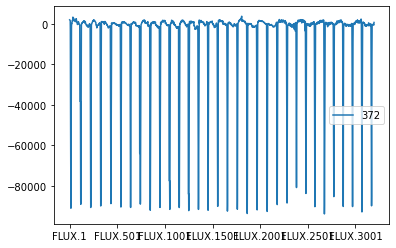

In [130]:
ax2 = a.plot()

In [131]:
# false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]

In [132]:
y_pred = model_KNN_SMOTE.predict(prepared_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [133]:
y_pred_proba = model_KNN_SMOTE.predict_proba(prepared_test)
y_pred_proba

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [134]:
i=0

for i in range(len(y_pred)):
    if y_test[i] ==0 and y_pred[i].T == 1:
        print("False Positive : " + str(i))
    if y_test[i] == 1 and y_pred[i].T == 0 :
        print("False Negative  : " + str(i))
    i+=1

False Negative  : 0
False Negative  : 1
False Negative  : 3
False Negative  : 4
False Positive : 246
False Positive : 308
False Positive : 560


In [135]:
# y_pred[372]

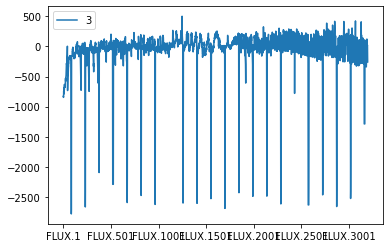

In [136]:
a = test_data[3:4].copy()
# show
a = a.T
a = a[1:-1]
ax2 = a.plot()

Text(0.5, 1.0, 'CONFUSION MATRIX')

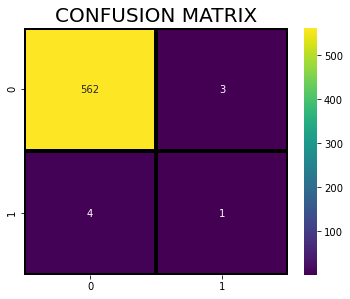

In [137]:
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_KNN_SMOTE.predict(prepared_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

In [138]:
# y_pred2 = model_DT_SMOTE.predict(prepared_test)

In [139]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('Precision score:',precision_score(y_test, y_pred))
print('Recall score:',recall_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))

ROCAUC score: 0.5973451327433629
Accuracy score: 0.987719298245614
Precision score: 0.25
Recall score: 0.2
F1 score: 0.22222222222222224


Text(0.5, 1.0, 'CONFUSION MATRIX')

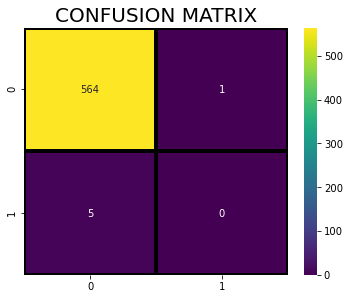

In [140]:
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_RF_SMOTE.predict(prepared_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

Text(0.5, 1.0, 'CONFUSION MATRIX')

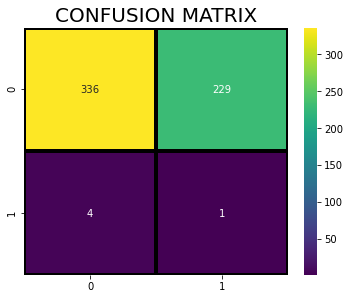

In [141]:
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_LR_SMOTE.predict(prepared_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

Text(0.5, 1.0, 'CONFUSION MATRIX')

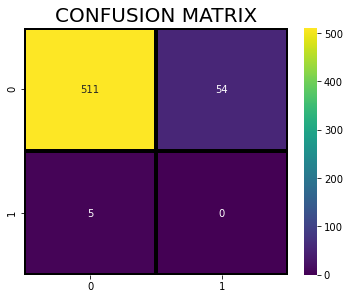

In [142]:
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_DT_SMOTE.predict(prepared_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

In [143]:
from sklearn.model_selection import GridSearchCV

In [144]:
def display_grid(grid):
    cvr = grid.cv_results_
    for mean_score, params in zip(cvr['mean_test_score'], cvr['params']):
        print(np.sqrt(-mean_score), params)

In [145]:
param_grid = {'n_neighbors':np.arange(3,15),
             'metric':['euclidean','manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,  scoring='neg_mean_squared_error', return_train_score=True, verbose=5)
grid.fit(prepared_train, y_train)
print(grid.best_params_)
display_grid(grid)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] metric=euclidean, n_neighbors=3 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

# DU COUP LA VERIF A L'AIR DE FONCTIONNER APRES ENTRAINEMENT

## A tester avec les elements du fichier test ?

## ANN

In [ ]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(learning_rate=0.0001)

In [ ]:
model11 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation='relu', input_shape=(1,train_X.shape[1])),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model11.compile(loss='binary_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [ ]:
history2 = model11.fit(train_X,
                      train_y,
                      validation_split=0.2,
                    epochs=200,
                    batch_size= 40)

In [ ]:
predict_model_test = model11.predict(test_X)

rounded_predictions_test = np.argmax(predict_model_test, axis=-1)

cm = confusion_matrix(test_y, y_pred=rounded_predictions_test)

print(cm)


In [ ]:

print(classification_report(test_y, rounded_predictions_test, zero_division=1))

In [ ]:
def learning_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
learning_curve(history2)

In [ ]:
opt2 = optimizers.Adam(learning_rate=0.00001)

In [ ]:
model12 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation='tanh', input_shape=(1,X_train.shape[1])),
    tf.keras.layers.Dense(40, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='tanh')
])

In [ ]:
model12.compile(loss='binary_crossentropy',
             optimizer=opt2,
             metrics=['accuracy'])

In [ ]:
history3 = model12.fit(train_X,
                      train_y,
                      validation_split=0.2,
                    epochs=200,
                    batch_size= 40)

In [ ]:
predict_model_test = model12.predict(test_X)

rounded_predictions_test = np.argmax(predict_model_test, axis=-1)

cm = confusion_matrix(test_y, y_pred=rounded_predictions_test)

print(cm)


In [ ]:

print(classification_report(test_y, rounded_predictions_test, zero_division=1))

In [ ]:
learning_curve(history3)

# TESTS

In [ ]:
predict_model_test = model12.predict(train_X)

rounded_predictions_test = np.argmax(predict_model_test, axis=-1)

cm = confusion_matrix(train_y, y_pred=rounded_predictions_test)

print(cm)

In [ ]:
print(classification_report(train_y, rounded_predictions_test, zero_division=1))

In [ ]:

print(model_RF_SMOTE.__class__.__name__, model_RF_SMOTE.score(X_test, y_test))
print(confusion_matrix(y_test, model_RF_SMOTE.predict(X_test)))

In [ ]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,model_RF_SMOTE.predict(X_test)),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)